### EDA, подготовка данных, варианты решения

По условию задачи, intent detection прелагается сводить к мультиклассовой классификации, поэтому здесь я хочу проверить характеристики датасета, которые могут влиять на качество классификатора:
  * количество классов
  * количество сэмплов по классам
  * баланс классов
  * наличие доминирующего класса (или нескольких) 
  * наличие outliers
  
В отношении самих текстов, проверяю, нужен ли какой-то препроцессинг.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import yaml

In [3]:
!ls ../data

dataset.csv  hello_nova_intents_0.2.2.yaml


In [4]:
def read_to_df(filename):
    with open(filename, 'r') as file:
        documents = yaml.full_load(file)

        samples = []
        for entry in documents['data']:
            intent = entry['intent']
            for example in entry['examples']:
                samples.append((example, intent))
            
    df = pd.DataFrame(samples, columns=['text', 'intent'])
    return df

In [5]:
df = read_to_df('../data/hello_nova_intents_0.2.2.yaml')
df.head(30)

,text,intent
0,Hi,Hello
1,Hello,Hello
2,"Hi, bot",Hello
3,Good morning,Hello
4,Good afternoon,Hello
5,Good evening,Hello
6,Morning,Hello
7,Evening,Hello
8,Hey,Hello
9,Good day,Hello


In [6]:
df.describe()

,text,intent
count,483,483
unique,472,71
top,How are you different from other bots?,How does it work?
freq,2,28


### Дубликаты

In [7]:
df['text'][df['text'].duplicated()]

41                       How can you help me?
48                    What can you do for me?
56                          What is your aim?
57                    What are you meant for?
58                        How do you operate?
59            What are your responsibilities?
60                  What are you designed to?
135                          Can I trust you?
138                      Why can I trust you?
291    How are you different from other bots?
399                          Are you a human?
Name: text, dtype: object

11 фраз дублируются. 

* Все фразы интента "Can I trust you?" (т.е. фразы "Can I trust you?" и "Why can I trust you?") также входят в интент "(6) security". Т.о., интент "Can I trust you?" избыточный и подлежит удалению.
* Фразы "What is your aim?", "What are you meant for?", "How do you operate?", "What are your responsibilities?", "What are you designed to?" входят в один и тот же интент (How does it work?) дважды.
* How are you different from other bots? -- входит в "(1) analogy" и в "(2) analogy". Откуда-то стоит удалить.
* Are you a human? -- это единственная фраза в интенте "Are you a human?", также входит в "(1) nature". Т.о. интент "Are you a human?" избыточный и подлежит удалению.
* How can you help me? -- входит в "How can you help me?" и в "How does it work?". Судя по названиям интентов, фразу нужно удалить из "How does it work?".
* What can you do for me? -- входит в "What can you do for me?" и в "How does it work?". Судя по названиям интентов, фразу нужно удалить из "How does it work?".

In [8]:
df = df.drop(df[df.intent == 'Can I trust you?'].index)
df = df.drop(df[df.intent == 'Are you a human?'].index)
df = df.drop(df[(df.text == 'How are you different from other bots?') & (df.intent == '(2) analogy')].index)
df = df.drop(df[(df.text == 'How can you help me?') & (df.intent == 'How does it work?')].index)
df = df.drop(df[(df.text == 'What can you do for me?') & (df.intent == 'How does it work?')].index)
df = df.drop_duplicates()

In [9]:
df.describe()

,text,intent
count,472,472
unique,472,69
top,Hi,How does it work?
freq,1,21


### Баланс классов

In [10]:
df['intent'].value_counts()

How does it work?               21
ask_name                        14
(2) 24/7 support                13
How are you?                    11
(1) language                    11
                                ..
(5) rules                        5
who_are_you                      4
What are you based on?           2
Why can't you understand me?     1
What is this for?                1
Name: intent, Length: 69, dtype: int64

<AxesSubplot:>

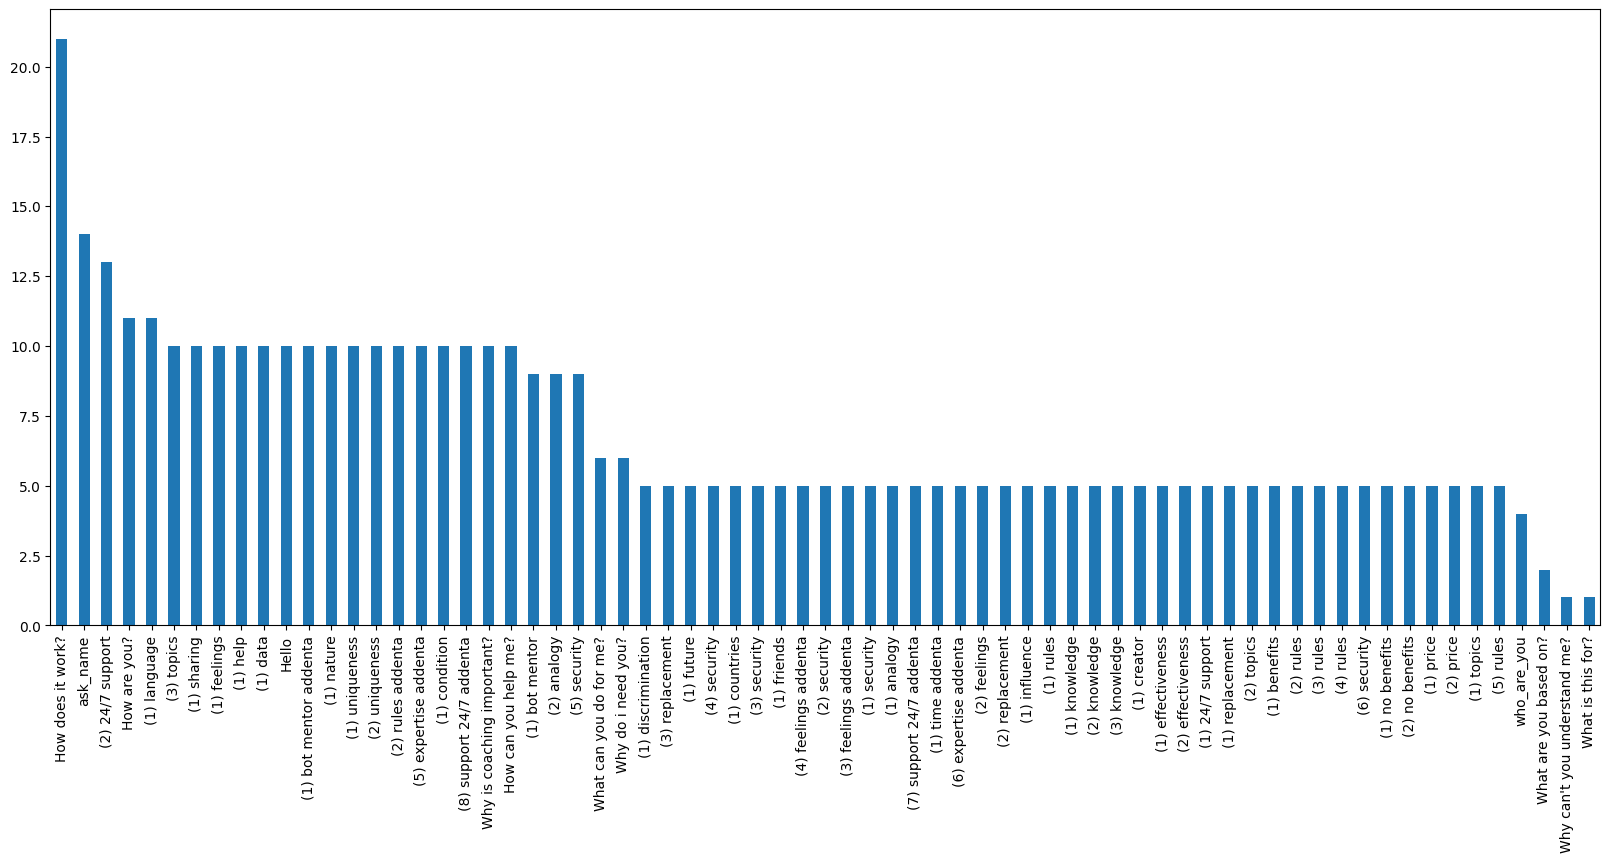

In [11]:
df['intent'].value_counts().plot(kind='bar', figsize=(20, 8))

Дедуплицированный датасет не сбалансирован. Есть два класса, представленные единичными примерами, один класс с двумя примерами. Явного доминирующего класса нет (самый населенный класс составляет около 4.5% от общего числа примеров). Однако, для значительной части классов разброс по числу примеров доходит до двух раз (5 vs. 10). В качестве компенсирующей меры предлагается сгруппировать классы "What are you based on?", "Why can't you understand me?" и "What is this for?" в общий класс "other".

In [12]:
df.loc[
    df['intent'].isin([
        'What are you based on?', 
        'Why can\'t you understand me?', 
        'What is this for?'
    ]), 'intent'] = 'other'

df.describe()

,text,intent
count,472,472
unique,472,67
top,Hi,How does it work?
freq,1,21


In [13]:
df.to_csv('../data/dataset.csv')

### Замечания по поводу структуры интентов

Можно попытаться привести структуру интентов к виду таксономии (дерева), а задачу определения интентов 
к каскаду классификаторов. При этом на каждом уровне таксономии можно контролировать количество подынтентов 
(например, ограничить их числом в пределах 5-10), и тем самым добиться улучшения качества классификаторов за счет уменьшения числа классов и, как следствие, увеличения числа точек на класс.